# Deep Convolutional - Realistic Image Colorization
Image colorization of grayscale to LAB directly. This is order to see the limitation of using RGB as the output when computing the loss.

In [ ]:
%pip install -q imageio pydot tensorflow-gpu==2.9.3 keras matplotlib graphviz moviepy scikit-image

## Import all Modules and Configure GPU

In [2]:
import os
import keras_tuner as kt
from numpy import asarray
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import pathlib
import os.path
import math
import PIL
import PIL.Image
import imageio.v2 as imageio
import glob
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" # Debug only

## Configure GPU

In [3]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    #mixed_precision.set_global_policy('mixed_float16')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
# Initialize tf.distribute.MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=None)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


2023-05-19 04:18:46.302542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-19 04:18:46.302793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-19 04:18:46.618850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-19 04:18:46.619054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-19 04:18:46.619211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [4]:
tf.__version__

'2.9.1'

### Setup Result Directory

In [5]:
root_dir = "result/realistic_colorizing_lab_color_space"
if not os.path.exists(root_dir):
    os.mkdir(root_dir)

## Load and process data.
Will take advantage of built in tensorflow/keras for asynchronous load dataset from disk, rather force all data to be loaded in memory.

In [6]:
def load_from_directory(data_dir, train_subdir, test_subdir, image_size, batch_size):
    def configure_for_performance(ds, AUTOTUNE, shuffleSize=0):
        BUFFER_SIZE = 10000
        if shuffleSize > 0:
            ds = ds.shuffle(buffer_size=shuffleSize, reshuffle_each_iteration=False)
        #ds = ds.cache(filename='/tmp/RealisticColorizing', name='RealisticColorizing')
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    #
    data_train_dir = pathlib.Path(data_dir.as_posix() + "/" + train_subdir)
    image_count = len(list(data_train_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_train_dir, image_count))

    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_train_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)

    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)

    # Translate [0,255] -> [0, 1]
    normalized_train_ds = train_ds.map(lambda x: normalization_layer(x) * 2.0 - 1.0)

    return configure_for_performance(tf.data.Dataset.zip((normalized_train_ds, normalized_train_ds)), AUTOTUNE, 256)


In [7]:
IMAGE_SIZE = (128, 128)

EPOCHS = 64

BATCH_SIZE_PER_REPLICA = 32
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

data_directory_path = "realistic-data-colorize/"
data_dir = pathlib.Path(data_directory_path)

train_images = load_from_directory(data_dir, "", "", IMAGE_SIZE, BATCH_SIZE)  # .batch(batch_size=BATCH_SIZE)

print("Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))

IMAGE_SIZE = (128, 128, 3)

realistic-data-colorize: Found 156299 files
Found 222057 files belonging to 1 classes.
Number of batches 3470 of 64 elements


## Augment Data

In [8]:

trainAug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(
        height_factor=(-0.05, -0.10),
        width_factor=(-0.05, -0.10)),
    layers.RandomRotation(0.4)
])

def AgumentFunc(x, y):
    aX = trainAug(x)
    return (tf.image.rgb_to_grayscale(aX), aX)


# apply augmentation image transformation to prevent overfitting.
trainAugmentedDS = (
    train_images
    .map(AgumentFunc,
         num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Split data into train and validation
ds_size = len(trainAugmentedDS)
train_size = int(0.8 * ds_size)
val_size = int(0.2 * ds_size)
# Split data into train and validation
train_ds = trainAugmentedDS.take(train_size)
val_ds = trainAugmentedDS.skip(train_size).take(val_size)

# Setup to support multiple GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_ds = train_ds.with_options(options)
# Setup to support multiple GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
val_ds = val_ds.with_options(options)


## Present DataSet Examples

2023-05-19 04:19:55.056874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 61 of 256
2023-05-19 04:20:05.067204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 129 of 256
2023-05-19 04:20:15.106493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 192 of 256
2023-05-19 04:20:22.141243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-19 04:20:22.142413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-19 04:20:22.688836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 04:20:22.697800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 04:20:24.662247: W tensorflow/core/lib/png/png_io.

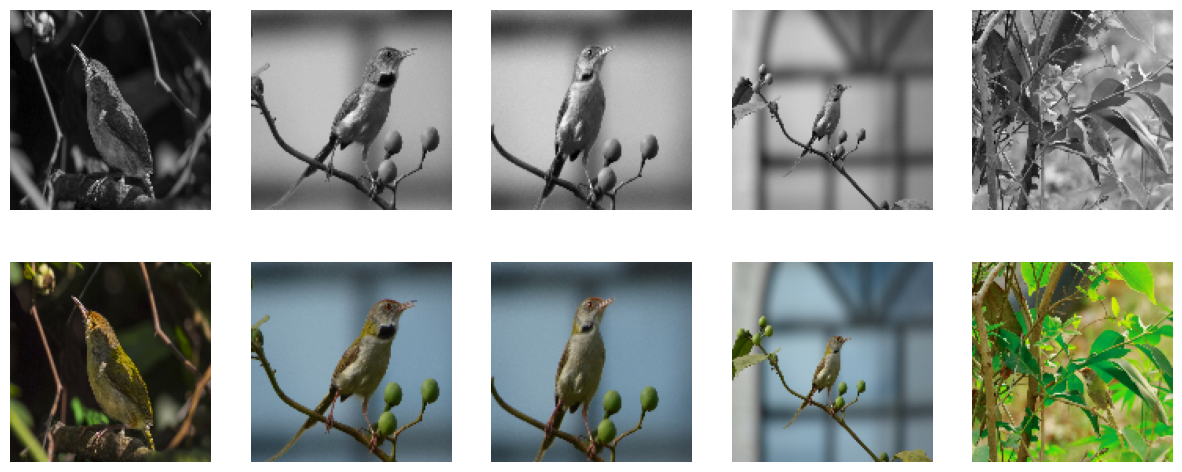

In [9]:

num_examples_to_generate = 5

bathc_iter = iter(train_images)
image_batch, expected_batch = next(bathc_iter)

plt.figure(figsize=(15, 6))
for i in range(0, num_examples_to_generate):
    ax = plt.subplot(2, num_examples_to_generate, i + 1)
    trainImage, expectedImage = (image_batch[i % len(image_batch)], expected_batch[i % len(expected_batch)])  # (images + 1.0) / 2.0
    # Transform pixel values from [-1,1] to [0,1]
    plt.imshow((tf.image.rgb_to_grayscale(trainImage[:, :, :]).numpy().astype(dtype='float32') + 1.0) / 2.0, cmap='gray')
    plt.axis("off")
    ax = plt.subplot(2, num_examples_to_generate, num_examples_to_generate + 1 + i)
    # Transform pixel values from [-1,1] to [0,1]
    plt.imshow((expectedImage[:, :, :].numpy().astype(dtype='float32') + 1.0) / 2.0)
    plt.axis("off")
    if len(image_batch) - 1 == i:
        image_batch, expected_batch = next(bathc_iter)
plt.show()


### Augmented DataSet Example

2023-05-19 04:20:40.009518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 87 of 256
2023-05-19 04:20:50.035361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 174 of 256
2023-05-19 04:20:57.082004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-19 04:20:57.202927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-19 04:20:57.455826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 04:20:57.577022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 04:20:58.843387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 04:20:58.847956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known 

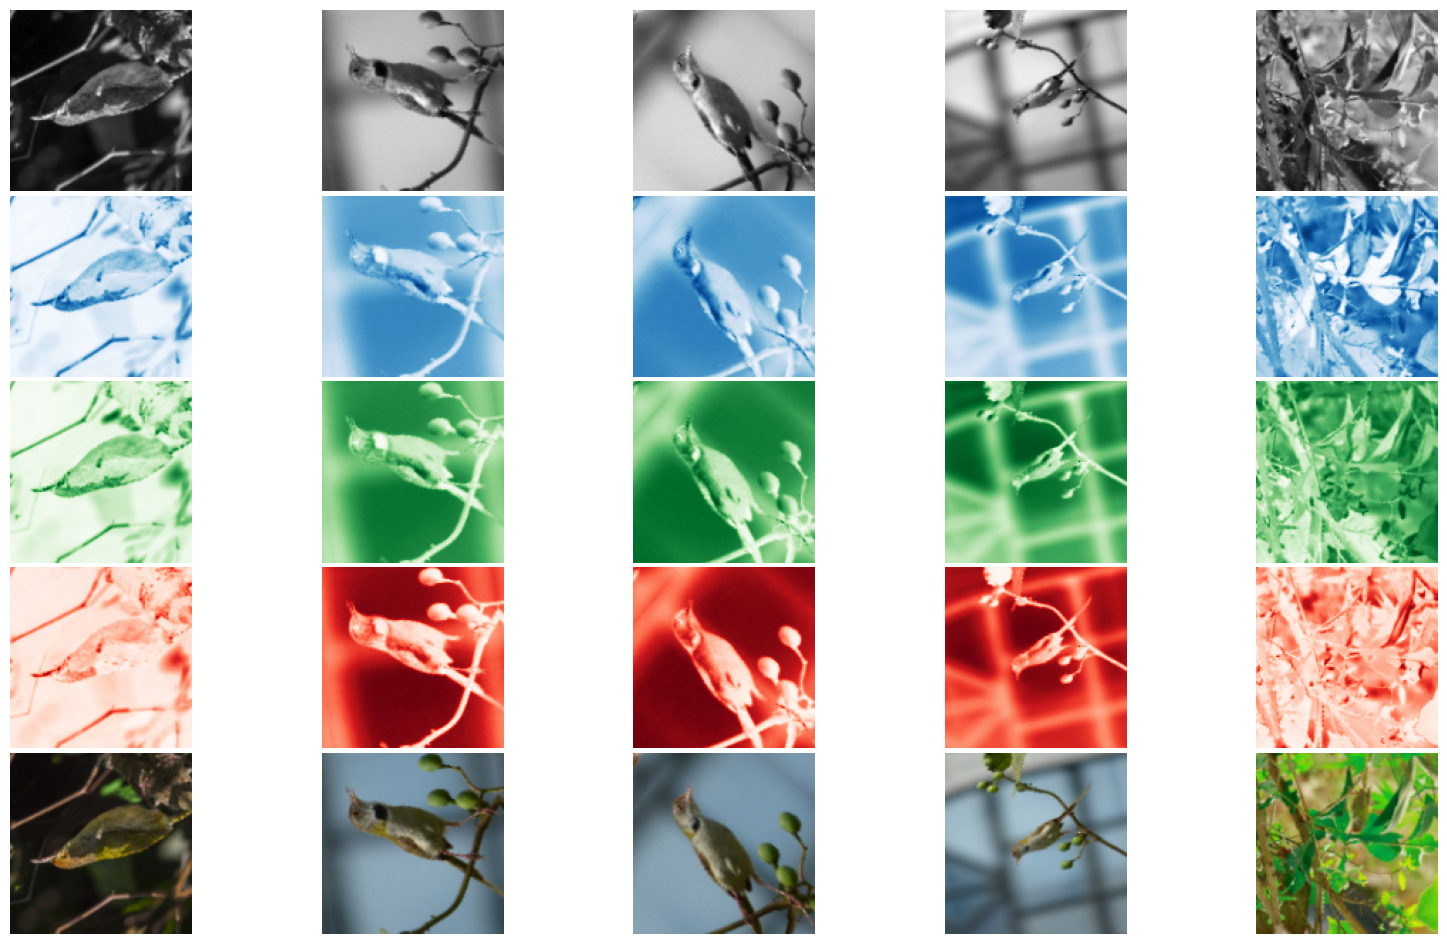

In [10]:
num_examples_to_generate = 9

bathc_iter = iter(train_ds)
image_batch, expected_batch = next(bathc_iter)

nrCol = 5
plt.figure(figsize=(10 * 2, 12))
for i in range(0, 5):

    trainImage, expectedImage = (image_batch[i % len(image_batch)], expected_batch[i % len(expected_batch)])  # (images + 1.0) / 2.0

    # Transform pixel values from [-1,1] to [0,1]
    trainImage = (trainImage + 1.0) / 2.0
    expectedImage = (expectedImage + 1.0) / 2.0

    ax = plt.subplot(5, nrCol, nrCol * 0 + i + 1)
    plt.imshow(trainImage[:, :, :].numpy().astype(dtype='float32'), cmap='gray')
    plt.axis("off")

    ax = plt.subplot(5, nrCol, nrCol * 1 + i + 1)
    plt.imshow(expectedImage[:, :, 0].numpy().astype(dtype='float32'), cmap='Blues')
    plt.axis("off")

    ax = plt.subplot(5, nrCol, nrCol * 2 + i + 1)
    plt.imshow(expectedImage[:, :, 1].numpy().astype(dtype='float32'), cmap='Greens')
    plt.axis("off")

    ax = plt.subplot(5, nrCol, nrCol * 3 + i + 1)
    plt.imshow(expectedImage[:, :, 2].numpy().astype(dtype='float32'), cmap='Reds')
    plt.axis("off")

    ax = plt.subplot(5, nrCol, nrCol * 4 + i + 1)
    plt.imshow(expectedImage[:, :, :])
    plt.axis("off")

    if len(image_batch) - 1 == i:
        image_batch, expected_batch = next(bathc_iter)
plt.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()


## Creating The Model
The model is created, similar to a audo encoding. However, in this model, there is node latent space. Instead it uses more of pure convolution network.

In [11]:
def create_model(hp, input_shape,image_output_shape):
    model = tf.keras.Sequential()

    kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                                   'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    model.add(layers.Input(input_shape))

    num_layers = hp.Int('number_of_layers', min_value=2, max_value=4, step=1)

    hp_kernel_filter_size_l0 = hp.Int('kernel_filter_downscale', min_value=5, max_value=7, step=1)

    for i in range(0, num_layers + 1):
        filter_size = 2 ** (i + hp_kernel_filter_size_l0)

        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))
        
        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', strides=2, kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))

        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))
        #model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    hp_kernel_filter_size_l1 = hp.Int('kernel_filter_upscale', min_value=5, max_value=7, step=1)

    for i in range(0, num_layers + 1):
        filter_size = 2 ** (hp_kernel_filter_size_l1 - i)

        #model.add(layers.Conv2D(filter_size, (2, 2), strides=(2, 2), activation='relu', padding='same'))
        model.add(layers.UpSampling2D(size=(2, 2)))

        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))

        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))

    model.add(layers.Conv2D(image_output_shape[2], (3, 3), padding='same', kernel_initializer=kernel_init))
    model.add(layers.Activation(activation='tanh', dtype='float32'))

    mse_magnitude = hp.Float('mse_magnitude', 0, 1.0, step=0.1, default=0.0)
    hp_optimizer = hp.Choice('optimizer', ['sgd', 'adam', 'rmsprop'])

    def ssim_loss(y_true, y_pred):
        return (1.0 - mse_magnitude) * (1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))) + mse_magnitude * tf.keras.losses.mean_squared_error(y_true, y_pred)

    model.compile(optimizer=hp_optimizer,
                  loss=ssim_loss,
                  metrics=[ssim_loss,'accuracy'])

    return model


## Hyperparameter

In [12]:

image_input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
image_output_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)


def model_builder(hp):
    with strategy.scope():
        model = create_model(hp, image_input_shape, image_output_shape)
        return model


best_models = None
model = None

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=16,
                     factor=5,
                     directory=os.path.join(root_dir, 'cache'),
                     project_name=str.format('Colorizing - GrayScale Input - {0}', "Realistic"))

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5)
tuner.search(train_ds.take(1000), epochs=EPOCHS, batch_size=BATCH_SIZE,
             callbacks=[stop_early, tf.keras.callbacks.TerminateOnNaN()], validation_data=train_ds.skip(1000).take(250), verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_models = tuner.get_best_models(4)

model = tuner.hypermodel.build(best_hps)
model.summary()


Trial 13 Complete [01h 27m 07s]
val_accuracy: 0.410827100276947

Best val_accuracy So Far: 0.5597816109657288
Total elapsed time: 05h 38m 19s
INFO:tensorflow:Oracle triggered exit
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 128, 128, 128)     1280      
                                                                 
 re_lu_15 (ReLU)             (None, 128, 128, 128)     0         
                                                                 
 conv2d_17 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 re_lu_16 (ReLU)             (None, 64, 64, 128)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 256)       295168    
                                                                 
 re_lu

In [13]:
def showResult(model, batchImage):
    maxNumImages = 5

    # TODO fix
    pred = (model.predict(batchImage) + 1.0) / 2.0

    train_batch_iter = iter(batchImage)
    train_image_batch, _ = next(train_batch_iter)

    predict_batch_iter = iter(pred)

    nrCol = 5
    fig = plt.figure(figsize=(maxNumImages * 4, maxNumImages*2))

    for i in range(0, 5):

        trainImage = train_image_batch[i % len(train_image_batch)]  # (images + 1.0) / 2.0
        expectedImage = next(predict_batch_iter)

        # Transform pixel values from [-1,1] to [0,1]
        trainImage = (trainImage + 1.0) / 2.0

        ax = plt.subplot(5, nrCol, nrCol * 0 + i + 1)
        plt.imshow(trainImage[:, :, :].numpy().astype(dtype='float32'), cmap='gray')
        plt.axis("off")

        ax = plt.subplot(5, nrCol, nrCol * 1 + i + 1)
        plt.imshow(expectedImage[:, :, 0].astype(dtype='float32'), cmap='Blues')
        plt.axis("off")

        ax = plt.subplot(5, nrCol, nrCol * 2 + i + 1)
        plt.imshow(expectedImage[:, :, 1].astype(dtype='float32'), cmap='Greens')
        plt.axis("off")

        ax = plt.subplot(5, nrCol, nrCol * 3 + i + 1)
        plt.imshow(expectedImage[:, :, 2].astype(dtype='float32'), cmap='Reds')
        plt.axis("off")

        ax = plt.subplot(5, nrCol, nrCol * 4 + i + 1)
        plt.imshow(expectedImage[:, :, :].astype(dtype='float32'))
        plt.axis("off")

        if len(train_image_batch) - 1 == i:
            train_image_batch, _ = next(train_batch_iter)
    plt.subplots_adjust(wspace=0.025, hspace=0.025)

    return fig

class save_images(tf.keras.callbacks.Callback):

    def __init__(self, trainData, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)

        def ColorizeFunc(x, y):
            return (tf.image.rgb_to_grayscale(x), y)

        self.trainData = trainData.map(ColorizeFunc,
                                       num_parallel_calls=tf.data.AUTOTUNE)
        # Setup to support multiple GPUs
        options = tf.data.Options()
        options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
        self.trainData = self.trainData.with_options(options)

    def on_epoch_end(self, epoch, logs=None):
        fig = showResult(self.model, self.trainData.take(1))
        fig.savefig(os.path.join(root_dir, "realistic_coloring_lab_colorspace_epoch_{0}.png".format( epoch)))
        plt.close()


## Train the Final Select Model

In [14]:


model_history = {}

checkpoint_path = "{0}/checkpoints/cp.ckpt".format(root_dir)
checkpoint_dir = os.path.dirname(checkpoint_path)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()

# The model weights (that are considered the best) are loaded into the model.
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)


model_history = model.fit(train_ds,
                          epochs=EPOCHS,
                          verbose=1, callbacks=[cp_callback, save_images(train_images)])


model.save_weights(checkpoint_path)


Epoch 1/64


2023-05-19 10:01:12.145292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 86 of 256
2023-05-19 10:01:22.153827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 173 of 256
2023-05-19 10:01:29.029216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-19 10:01:29.425971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:01:29.451014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-19 10:01:29.801468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:01:30.786414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:01:30.793355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known 

  32/2776 [..............................] - ETA: 10:56 - loss: 0.2991 - ssim_loss: 0.2991 - accuracy: 0.3467

2023-05-19 10:01:39.859232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:01:40.040760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  35/2776 [..............................] - ETA: 10:50 - loss: 0.3003 - ssim_loss: 0.3003 - accuracy: 0.3505

2023-05-19 10:01:40.621885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:01:40.797854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  44/2776 [..............................] - ETA: 10:41 - loss: 0.2971 - ssim_loss: 0.2971 - accuracy: 0.3438

2023-05-19 10:01:42.631905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  45/2776 [..............................] - ETA: 10:42 - loss: 0.2969 - ssim_loss: 0.2969 - accuracy: 0.3474

2023-05-19 10:01:42.863394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2763/2776 [============================>.] - ETA: 2s - loss: 0.4053 - ssim_loss: 0.4053 - accuracy: 0.4995

2023-05-19 10:11:36.261108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:11:36.261150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2767/2776 [============================>.] - ETA: 1s - loss: 0.4052 - ssim_loss: 0.4052 - accuracy: 0.4994

2023-05-19 10:11:37.170689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:11:37.170720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2776/2776 [==============================] - ETA: 0s - loss: 0.4050 - ssim_loss: 0.4050 - accuracy: 0.4996

2023-05-19 10:11:51.724324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 57 of 256
2023-05-19 10:12:01.539791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 117 of 256
2023-05-19 10:12:11.666773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 184 of 256
2023-05-19 10:12:20.492329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-19 10:12:20.492502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-19 10:12:21.020980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:12:21.058413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:12:21.703808: I tensorflow/core/kernels/data/sh

1/1 [==============================] - 44s 44s/step


2023-05-19 10:12:24.553408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-19 10:12:34.797973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 87 of 256
2023-05-19 10:12:44.803193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 174 of 256
2023-05-19 10:12:51.994774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-19 10:12:52.012333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-19 10:12:52.396691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:12:52.434320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:12:53.737359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorre

2776/2776 [==============================] - 717s 246ms/step - loss: 0.4050 - ssim_loss: 0.4050 - accuracy: 0.4996
Epoch 2/64


2023-05-19 10:13:05.673539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 84 of 256
2023-05-19 10:13:15.702320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 174 of 256
2023-05-19 10:13:22.753587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-19 10:13:22.881637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-19 10:13:23.123172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:13:23.262809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:13:24.481508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:13:24.489115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known 

  47/2776 [..............................] - ETA: 10:34 - loss: 0.3123 - ssim_loss: 0.3123 - accuracy: 0.4090

2023-05-19 10:13:36.670703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:13:36.670797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  62/2776 [..............................] - ETA: 10:29 - loss: 0.3049 - ssim_loss: 0.3049 - accuracy: 0.4096

2023-05-19 10:13:40.101219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:13:40.101621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  82/2776 [..............................] - ETA: 11:26 - loss: 0.3029 - ssim_loss: 0.3029 - accuracy: 0.4107

2023-05-19 10:13:46.500707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:13:46.501060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2761/2776 [============================>.] - ETA: 3s - loss: 0.4061 - ssim_loss: 0.4061 - accuracy: 0.5103

2023-05-19 10:23:24.156227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:23:24.156487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2767/2776 [============================>.] - ETA: 1s - loss: 0.4059 - ssim_loss: 0.4059 - accuracy: 0.5103

2023-05-19 10:23:25.514869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:23:25.514909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2776/2776 [==============================] - ETA: 0s - loss: 0.4057 - ssim_loss: 0.4057 - accuracy: 0.5104

2023-05-19 10:23:38.687576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 67 of 256
2023-05-19 10:23:48.589041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 133 of 256
2023-05-19 10:23:58.577934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 256
2023-05-19 10:24:04.945114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-19 10:24:04.945182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-19 10:24:05.494105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:24:05.500169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:24:07.463421: W tensorflow/core/lib/png/png_io.

1/1 [==============================] - 41s 41s/step


2023-05-19 10:24:08.968525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-19 10:24:19.180683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 80 of 256
2023-05-19 10:24:29.222565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 161 of 256
2023-05-19 10:24:38.058064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-19 10:24:38.206189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-19 10:24:38.457668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:24:38.568721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:24:39.207610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shu

2776/2776 [==============================] - 715s 247ms/step - loss: 0.4057 - ssim_loss: 0.4057 - accuracy: 0.5104
Epoch 3/64


2023-05-19 10:25:00.446542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 86 of 256
2023-05-19 10:25:10.454027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 174 of 256
2023-05-19 10:25:17.738582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-19 10:25:17.828699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-19 10:25:18.149841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:25:18.209425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:25:19.504823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:25:19.511963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known 

  42/2776 [..............................] - ETA: 10:37 - loss: 0.3182 - ssim_loss: 0.3182 - accuracy: 0.4052

2023-05-19 10:25:30.578044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:25:30.578082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  47/2776 [..............................] - ETA: 10:28 - loss: 0.3124 - ssim_loss: 0.3124 - accuracy: 0.4088

2023-05-19 10:25:31.554432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:25:31.554458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  82/2776 [..............................] - ETA: 13:24 - loss: 0.3028 - ssim_loss: 0.3028 - accuracy: 0.4104

2023-05-19 10:25:45.502382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-19 10:25:45.502412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 195/2776 [=>............................] - ETA: 13:51 - loss: 0.3079 - ssim_loss: 0.3079 - accuracy: 0.3920

In [ ]:
model.save("{0}/dc-realistic-colorization.h5".format(root_dir))


# Image Colorization Result

2023-05-12 04:50:27.205197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 172 of 256
2023-05-12 04:50:31.960547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1/1 [==============================] - 15s 15s/step


2023-05-12 04:50:42.578962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 172 of 256
2023-05-12 04:50:47.362986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


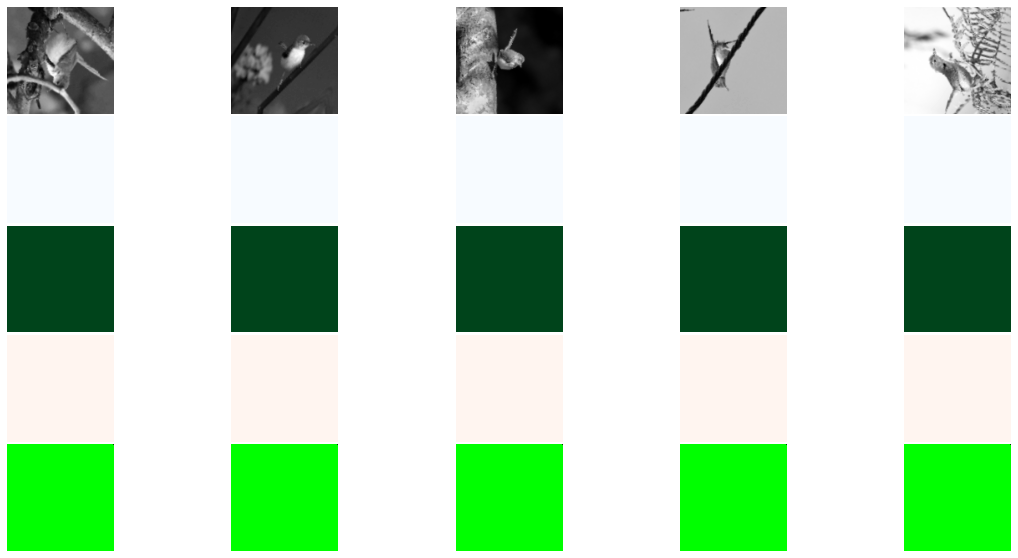

In [ ]:
fig = showResult(model, train_ds.take(1))
plt.show()

In [ ]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    plt.figure()
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    plt.show()
    plt.savefig(title + ".png")


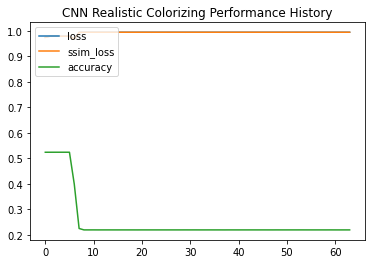

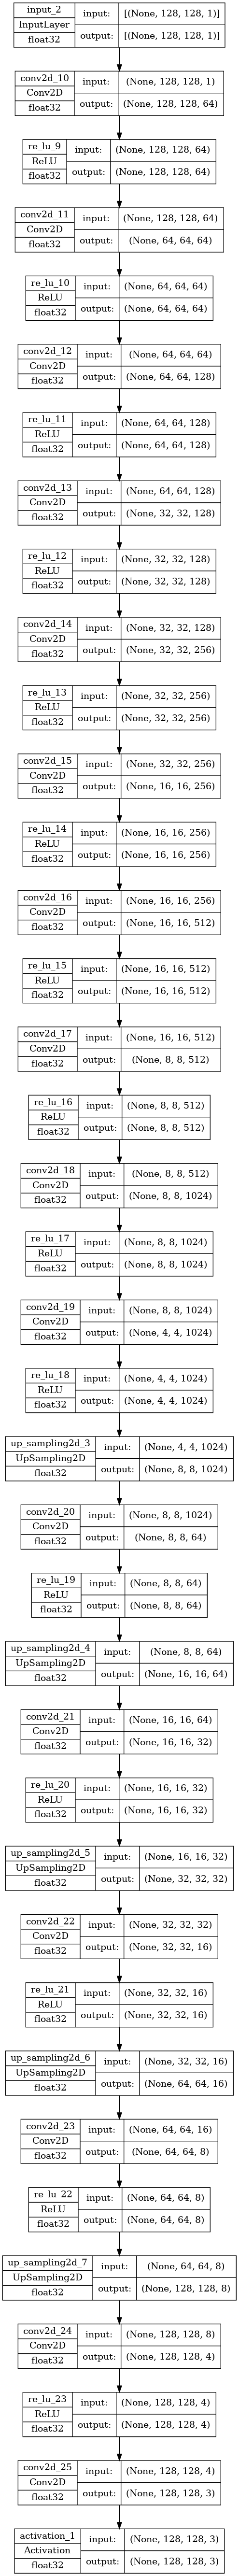

<Figure size 432x288 with 0 Axes>

In [ ]:
plotCostHistory(model_history.history, title=str.format(
    "CNN {0} Performance History", "Realistic Colorizing"))

tf.keras.utils.plot_model(
    model, to_file=str.format('{0}/cnn_{1}_model.png', root_dir, "Realistic Colorizing"), show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)
